# MakeMore 
### Character-level language modeling with context
Inspired by: [A Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

This notebook explores character-level language modeling. It includes data preprocessing, dataset construction, training a neural network, and generating text based on learned character relationships.

## Imports

In [150]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

## Loading and Processing the Data
We load the data (e.g., a list of names) from a text file and create mappings between characters and indices:

* `s2i`: Maps each character to a unique index,
* `i2s`: Maps indices back to their respective characters.

We also include a special marker (`.`) for word boundaries.

In [3]:
words = open('../names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
s2i = {s:i+1 for i,s in enumerate(chars)}
s2i['.'] = 0

i2s = {i:s for s,i in s2i.items()}

print(i2s)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


## Building the Dataset
The function build_dataset converts words into input-output pairs:

* Input (X): A context of fixed length (e.g., the previous 3 characters),
* Output (Y): The next character in the sequence.

The dataset is split into:

* Training set: 80% of the data,
* Validation set: 10%,
* Test set: 10%.

In [151]:
def build_dataset(words, block_size=3):
  """
  words: list of words 
  block_size: context lenght - how many characters do we take to predict the next one

  returns: X, Y
  """
  X, Y = [], []
  for word in words:
    # print(word)
    context = [0] * block_size
    for ch in word + '.':
      idx = s2i[ch]
      X.append(context)
      Y.append(idx)
      # print(''.join(i2s[i] for i in context), '--->', i2s[idx] )
      context = context[1:] + [idx]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words)) # 80% of the data
m2 = int(0.9*len(words)) # 90% of the data

Xtrain, Ytrain = build_dataset(words[:n1])
Xval, Yval = build_dataset(words[n1:m2])
Xtest, Ytest = build_dataset(words[m2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Building the Model
The neural network consists of:

1. Embedding matrix (C): Converts characters into vector representations.
2. Hidden layer: A fully connected layer with tanh activation.
3. Output layer: Produces logits for each possible character.

The parameters of the model are initialized randomly and optimized using backpropagation.

In [242]:
gen = torch.Generator().manual_seed(42)
C = torch.randn((27,10), generator=gen) # 27 characters, 10 dimensions
W1 = torch.randn((30,200), generator=gen)
b1 = torch.randn(200, generator=gen)

W2 = torch.randn((200,27), generator=gen)
b2 = torch.randn(27, generator=gen)
parameters = [C, W1, b1, W2, b2]

In [243]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

## Training the Model
### Process Overview:
1. Mini-batch sampling: Randomly select data samples.
2. Forward pass: Compute the loss (cross-entropy).
3. Backward pass: Calculate gradients using backpropagation.
4. Parameter update: Adjust weights using gradient descent.

Learning rates are dynamically adjusted during training:

* 0.1: For the first 100,000 iterations,
* 0.01: For the next 50,000 iterations,
* 0.001: For the remaining iterations.

In [244]:
for p in parameters:
  p.requires_grad = True

In [245]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [246]:
lri = []
lossi = []
stepi = []
for i in range(200000):

  # mini batch
  idx = torch.randint(0,Xtrain.shape[0],(32,))
  

  # forward pass
  emb = C[Xtrain[idx]] # 32x3x2
  h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32x200
  logits = h @ W2 + b2 # 32x27
  # efficient way to calculate the loss
  loss = F.cross_entropy(logits, Ytrain[idx])
  # print(loss.item())
  # backaward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # update
  # lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01 if i < 150000 else 0.001 
  for p in parameters:
    p.data -= p.grad * lr

  #track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


# print(loss.item())


non-efeficient way to calculate the loss

counts = logits.exp() # if logits are large, the exp() will be large or even infinite witch will cause numerical instability

For example logits = torch.tensor([-100, 0, 100]); counts = logits.exp() will return [0., 1, inf] and counts.sum() will be inf so probs will return nan. To avoid this we can subtract the maximum value from the logits to make the largest value 0. -> logits - logits.max() = [-200, -100, 0] -> counts = logits.exp() = [0., 0., 1] 

probs = counts / counts.sum(dim=1, keepdim=True)

loss = -probs[torch.arange(32),Y].log().mean()

## Model Evaluation
The model is evaluated on training, validation, and test sets. Loss values are computed using cross-entropy, and their trends are visualized over the training steps.

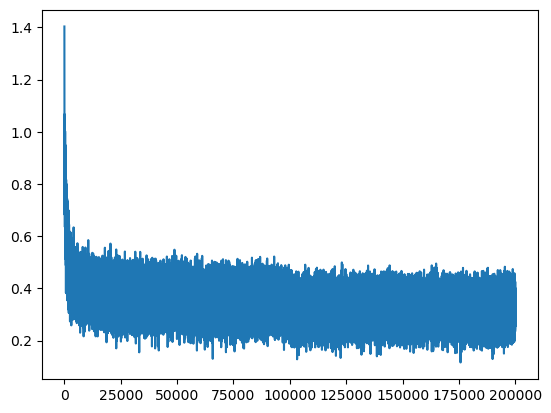

In [247]:
plt.plot(stepi,lossi)

In [248]:
emb = C[Xtrain] # 32x3x2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32x200
logits = h@ W2 + b2 # 32x27
# efficient way to calculate the loss
loss = F.cross_entropy(logits, Ytrain)
loss.item()

2.1131794452667236

In [249]:
emb = C[Xval] # 32x3x2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32x200
logits = h@ W2 + b2 # 32x27
# efficient way to calculate the loss
loss = F.cross_entropy(logits, Yval)
loss.item()

2.148298978805542

In [251]:
emb = C[Xtest] # 32x3x2
h = torch.tanh(emb.view(-1,30) @ W1 + b1) # 32x200
logits = h@ W2 + b2 # 32x27
# efficient way to calculate the loss
loss = F.cross_entropy(logits, Ytest)
loss.item()

2.146045446395874

### Character Embedding Visualization
The code generates a 2D scatter plot of character embeddings (projected onto the first two dimensions). Each character is labeled with its symbol.

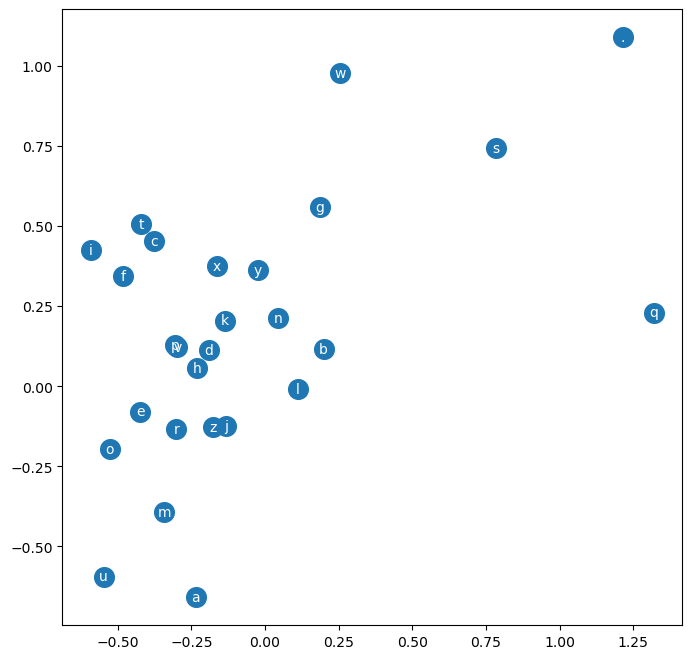

In [252]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), i2s[i],ha="center",va="center",color="white")

## Text Generation
The trained model generates text one character at a time by sampling from the predicted probability distribution. The process:

1. Initialize a context with zeros (representing the start of a word).
2. Predict the next character using the embedding and network layers.
3. Update the context and repeat until the end marker (`.`) is generated.

In [250]:
g = torch.Generator().manual_seed(42)
block_size = 3
for _ in range(20):
  out = []
  context = [0]*block_size
  while True:
    emb = C[torch.tensor([context])] #(1,block_size,dim)
    h = torch.tanh(emb.view(1,-1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    idx = torch.multinomial(probs,num_samples=1,generator=g).item()
    context = context[1:] + [idx]
    out.append(idx)
    if idx == 0:
      break
  print(''.join(i2s[i] for i in out))

yansyonne.
amendlee.
khalei.
nya.
try.
wendeen.
ena.
daya.
jiah.
abdeles.
lon.
toy.
ality.
maugo.
kandzello.
jastri.
xaina.
lun.
caylyn.
zeriagreen.


## Summary
The current implementation captures character-level dependencies but does not perform perfectly. Future improvements could include:

* Adding more context,
* Exploring deeper architectures,
* Training on larger datasets.

This notebook provides a solid foundation for further experiments in neural language modeling.